In [4]:
%load_ext autoreload
%autoreload 2

In [140]:
import multiprocessing
from multiprocessing import Pool
from bb_binary import FrameContainer, Repository, load_frame_container
import pandas as pd
import numpy as np
from collections import namedtuple 
import networkx as nx

from pandas import DataFrame, Series
from collections import Counter
import matplotlib.pyplot as plt
import bib.preprocessing as prep
import seaborn as sns
%matplotlib inline 

# How often and how long are bees absent and present

Looking at all bees for a complete day (24 hours), I want to find out how often a bee is present (detected) or absent (not detected) also looking at the distribution. Also how many bees are there in general (how many unique ids). And how long (how many 0 or 1 in a row) a bee is absent/present on average and also looking at the distribution would be nice.

In [153]:
path = "../../../../../../storage/mi/aschle/1day/20150822/"

In [154]:
# packt immer die 4 Kameradateien zusammen
def get_files(path):
    repo = Repository(path)
    file = list(repo.iter_fnames())
    a = [f.split('/')[-1].split("_")[1] for f in file]
    l = len(a)/4
    npa = np.array(file).reshape(int(l),4)
    return npa

In [155]:
files = get_files(path)

In [156]:
len(files)

253

In [157]:
pool = multiprocessing.Pool(18)

In [159]:
tasks = []

for e, f in enumerate(files):
    tasks.append((e, f, 0.95))

In [160]:
def generate_timeseries(index, file_list, confidence=.95):
    
    dataframes = DataFrame()
    
    for f in file_list:
        fc = load_frame_container(f)
        df = prep.get_dataframe2(fc)
        df = prep.calcIds(df,confidence)
        df['frame_idx'] = df['frame_idx'] + index*1024

        dataframes = pd.concat([dataframes, df])

    return dataframes

In [161]:
results = [pool.apply_async( generate_timeseries, t ) for t in tasks]

In [162]:
df = DataFrame()

In [163]:
for result in results:
    df = pd.concat([df,result.get()])

In [169]:
df.to_pickle("../../../../../.q./storage/mi/aschle/df.pickle")

In [170]:
def df_to_timeseries(df):
    gr = df.groupby('frame_idx')
    num_columns = len(df.frame_idx.unique())

    # get all unique ids von allen Frames
    u_id = df.id.unique()

    dft = DataFrame(0, index=u_id, columns=np.arange(num_columns))

    for i, group in gr:
        l = group['id']
        dft.loc[l,i] = 1

    return dft

In [171]:
%time dft = df_to_timeseries(df)

CPU times: user 25min 57s, sys: 11.2 s, total: 26min 9s
Wall time: 25min 52s


## Number of 1 per ID and number of 0 per ID

In [172]:
dft_summen = DataFrame()
dft_summen["sum1"] = dft.sum(axis=1)

In [173]:
dft_summen["sum0"] = (dft.shape[1]) - dft_summen['sum1']

In [174]:
# Numer of unique IDs
len(dft_summen.index)

4096

### Number of 1 = Bee is present

In [212]:
len(files)*1024

259072

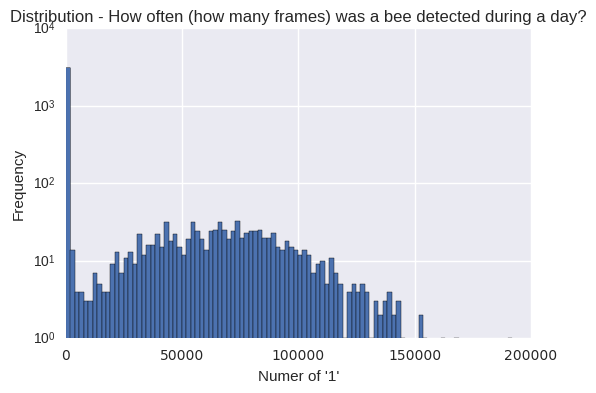

In [220]:
ax = dft_summen.sum1.hist(bins=100, log=True)
ax.set_xlabel("Numer of '1'")
ax.set_ylabel("Frequency")
ax.set_title("Distribution - How often (how many frames) was a bee detected during a day?")

In [176]:
freq = Counter(dft_summen.sum1)

In [177]:
dft_summen.sum1.describe()

count      4096.000000
mean      16616.937256
std       32545.368321
min           2.000000
25%          84.000000
50%         247.000000
75%        1426.500000
max      192029.000000
Name: sum1, dtype: float64

In [235]:
Series(freq).sort_values()

2         1
58232     1
58191     1
58138     1
58041     1
58000     1
57972     1
57924     1
57883     1
57839     1
57764     1
57670     1
58379     1
57593     1
57509     1
57412     1
57345     1
57342     1
57192     1
57089     1
57086     1
57075     1
56592     1
56254     1
56216     1
57547     1
56165     1
58518     1
58960     1
62130     1
         ..
52       15
65       15
43       15
81       15
31       15
92       15
131      16
42       16
30       16
79       16
85       16
86       16
28       16
54       17
49       17
41       17
53       17
58       18
84       18
35       18
39       19
50       20
46       20
25       20
37       21
33       22
36       23
51       26
23       27
34       31
dtype: int64

In [239]:
dft_summen[dft_summen.sum1 == 34]

,sum1,sum0
3190,34,259038
3980,34,259038
2553,34,259038
253,34,259038
3121,34,259038
3046,34,259038
3220,34,259038
3931,34,259038
189,34,259038
3165,34,259038


In [ ]:
dft = pd.read_pickle("../../../../../../storage/mi/aschle/dft.pickle")

In [262]:
ss = dft.iloc[484]
six = ss[ss==1].index
[(six[i+1]-j)/3 for i,j in enumerate(six[:-1])]

[32.333333333333336,
 264.33333333333331,
 2107.6666666666665,
 2089.3333333333335,
 1152.6666666666667,
 2015.6666666666667,
 433.66666666666669,
 2671.0,
 1875.0,
 589.33333333333337,
 62.333333333333336,
 3435.3333333333335,
 0.66666666666666663,
 0.33333333333333331,
 394.0,
 1716.3333333333333,
 1748.0,
 177.0,
 8.3333333333333339,
 4.0,
 507.66666666666669,
 3162.0,
 946.66666666666663,
 1869.3333333333333,
 21.666666666666668,
 142.66666666666666,
 1857.6666666666667,
 312.33333333333331,
 48.666666666666664,
 1387.3333333333333,
 3719.3333333333335,
 3486.0,
 672.0,
 873.66666666666663,
 923.33333333333337,
 3969.0,
 1660.0,
 2685.3333333333335,
 904.33333333333337,
 139.0,
 488.0,
 39.666666666666664,
 349.0,
 14.666666666666666,
 1264.6666666666667,
 816.33333333333337,
 424.0,
 1602.6666666666667,
 2483.0,
 2463.6666666666665,
 697.66666666666663,
 0.33333333333333331,
 1072.6666666666667,
 3010.6666666666665,
 136.66666666666666,
 334.0,
 3861.3333333333335,
 209.3333333333

In [242]:
s = Series([1,2,3,4])

In [247]:
s == 1

0     True
1    False
2    False
3    False
dtype: bool

### Number of 0 = Bee is absent :)))))

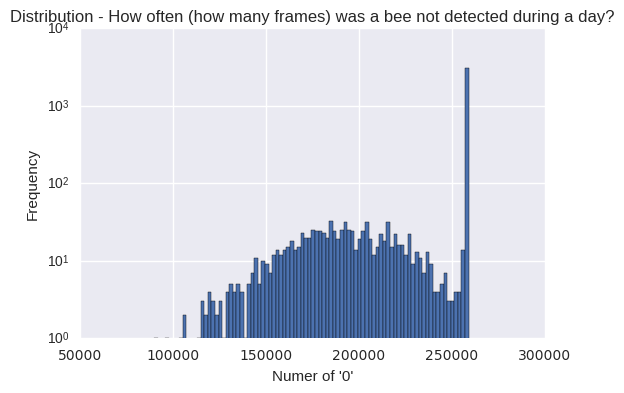

In [222]:
ax = dft_summen.sum0.hist(bins=100, log=True)
ax.set_xlabel("Numer of '0'")
ax.set_ylabel("Frequency")
ax.set_title("Distribution - How often (how many frames) was a bee not detected during a day?")

In [179]:
dft_summen.sum0.describe()

count      4096.000000
mean     242455.062744
std       32545.368321
min       67043.000000
25%      257645.500000
50%      258825.000000
75%      258988.000000
max      259070.000000
Name: sum0, dtype: float64

## Length of 1

In [180]:
%time chains1 = dft.apply(get_ketten_len, axis=1, args=["0"])

CPU times: user 10min 24s, sys: 8.4 s, total: 10min 32s
Wall time: 10min 25s


In [181]:
chains1.head()


2318    [5, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 2, 2, 1, ...
3308    [3, 1, 3, 4, 4, 6, 3, 1, 1, 5, 1, 2, 13, 10, 1...
2811    [421, 4, 93, 53, 22, 10, 74, 23, 3, 2, 39, 23,...
2386    [9, 19, 8, 8, 20, 7, 4, 2, 9, 6, 8, 1, 4, 3, 3...
3747    [8, 72, 3, 20, 21, 1, 2, 1, 1, 1, 1, 1, 6, 1, ...
dtype: object

In [182]:
list_1 = [j for i in chains1 for j in i]

In [183]:
def get_ketten_len(kette, val):
    kette = kette.apply(str)
    s = kette.str.cat(sep='')
    ss = s.split(val)
    return [len(x) for x in ss if len(x) > 0]

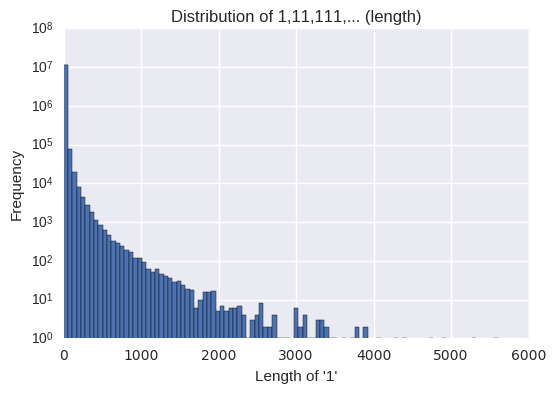

In [231]:
plt.hist(list_1, bins=100, log=True, )
plt.xlabel("Length of '1'")
plt.ylabel("Frequency")
plt.title("Distribution of 1,11,111,... (length)")

In [185]:
DataFrame(list_1).describe()

,0
count,1.149439e+07
mean,5.921407e+00
std,2.246038e+01
min,1.000000e+00
25%,1.000000e+00
50%,2.000000e+00
75%,5.000000e+00
max,5.606000e+03


### Length of 0

In [186]:
%time chains0 = dft.apply(get_ketten_len, axis=1, args=["1"])

CPU times: user 8min 4s, sys: 2.22 s, total: 8min 6s
Wall time: 8min 1s


In [187]:
list_0 = [j for i in chains0 for j in i]

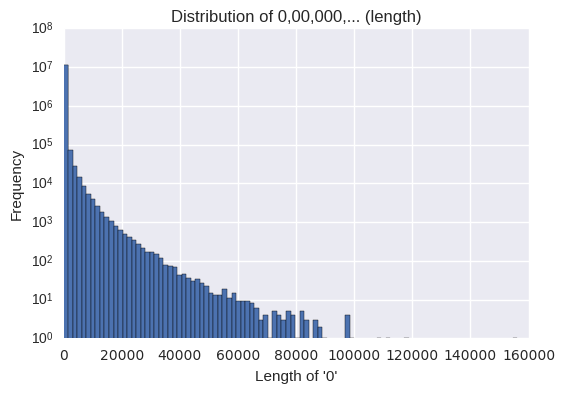

In [230]:
(n, bins, patches) = plt.hist(list_0, bins=100, log=True)
plt.xlabel("Length of '0'")
plt.ylabel("Frequency")
plt.title("Distribution of 0,00,000,... (length)")

In [189]:
DataFrame(list_0).describe()

,0
count,1.149801e+07
mean,8.637114e+01
std,8.006484e+02
min,1.000000e+00
25%,1.000000e+00
50%,2.000000e+00
75%,6.000000e+00
max,1.561670e+05


In [263]:
del dft

In [264]:
import gc
gc.collect()

15989

In [193]:
dft.to_pickle("../../../../../../storage/mi/aschle/dft.pickle")

In [194]:
del dft

In [195]:
gc.collect()

17

In [196]:
chains1.to_pickle("../../../../../../storage/mi/aschle/chains1.pickle")

In [197]:
chains0.to_pickle("../../../../../../storage/mi/aschle/chains0.pickle")

In [198]:
del chains1

In [199]:
del chains0

In [200]:
gc.collect()

17